## Garbage Classification: VGG Model
### Jing Lou
### Group Member: Fedor Grab, Salman Rafiullah, Chandra Maddikunta
In the initial report, we've decided to try three of the most popular models (VGG, InceptionV3, and customized) and compare their performance to find out the best performed model for this case. We then worked seperatly on each model. I've been focusing on the VGG16 model for most of the time, this notebook contains the VGG16 model We built and its performance evaluation.
<br>
Original Dataset: https://www.kaggle.com/andreasantoro/split-garbage-dataset

In [1]:
# Import Libraries
#!pip install tf-nightly
import numpy as np
import pandas as pd
import tensorflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Nadam

np.random.seed(0)

In [2]:
# Import the cleaned & splited dataset.
path = "D:/NEU/EAI6000/split-garbage-dataset/split-garbage-dataset"

In [3]:
train_data = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest'
)
validation_data = ImageDataGenerator(rescale = 1./255)
test_data = ImageDataGenerator(rescale = 1./255)

In addition, while normalized the images, I reshaped the input image and maintained the 3 channel (instead of gray scale) to preserve more feature and evaluate the model's performance on color images. The reason I made this concern is that some of the garbages might be hard to tell differences when they are in gray scale images. For example, glass bottle and plastic bottle.

In [4]:
set_shape = (200, 200, 3)

train_batch_size = 256
val_batch_size = 16

train_generator = train_data.flow_from_directory(
            path + '/train',
            target_size = (set_shape[0], set_shape[1]),
            batch_size = train_batch_size,
            class_mode = 'categorical',)

validation_generator = validation_data.flow_from_directory(
            path + '/valid',
            target_size = (set_shape[0], set_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False)

test_generator = test_data.flow_from_directory(
            path + '/test',
            target_size = (set_shape[0], set_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False,)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


### Building VGG Model

In [5]:
vgg = VGG16(weights = 'imagenet', include_top = False,input_shape = set_shape)

In [6]:
for layer in vgg.layers[:-3]:
    layer.trainable = False

In [7]:
model = Sequential()

model.add(vgg)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              18875392  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 33,596,230
Trainable params: 23,601,158
Non-trainable params: 9,995,072
_________________________________________________________________


In [9]:
# Model Compiling
model.compile(loss='categorical_crossentropy',
              optimizer=Nadam(lr=1e-4),
              metrics=['acc'])

In [10]:
# Training
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('VGG16 Garbage Classifier.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size ,
    epochs=35,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    verbose=0,
    callbacks = [es, mc],)

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: val_acc improved from -inf to 0.23780, saving model to VGG16 Garbage Classifier.h5

Epoch 00002: val_acc improved from 0.23780 to 0.31707, saving model to VGG16 Garbage Classifier.h5

Epoch 00003: val_acc improved from 0.31707 to 0.44817, saving model to VGG16 Garbage Classifier.h5

Epoch 00004: val_acc improved from 0.44817 to 0.46646, saving model to VGG16 Garbage Classifier.h5

Epoch 00005: val_acc improved from 0.46646 to 0.72256, saving model to VGG16 Garbage Classifier.h5

Epoch 00006: val_acc did not improve from 0.72256

Epoch 00007: val_acc did not improve from 0.72256

Epoch 00008: val_acc improved from 0.72256 to 0.75305, saving model to VGG16 Garbage Classifier.h5

Epoch 00009: val_acc improved from 0.75305 to 0.76524, saving model to VGG16 Garbage Classifier.h5

Epoch 00010: val_acc improved from 0.76524 to 0.79268, saving model to VGG16 Garbage Classifier.h5

Epoch 00011: val_acc did

### Model Testing (Evaluation)
As the above training & validation accuracy indicated, the validation performance of the model appears to be good. Let's use the test set to evaluate the model.

In [11]:
test_score = model.evaluate_generator(test_generator, 431/val_batch_size, workers=12)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [12]:
print("Test_Loss: ", test_score[0], "Test_Accuracy: ", test_score[1])

Test_Loss:  0.5046113133430481 Test_Accuracy:  0.8422273993492126


VGG16 model has a good performance on the train and validation set. However, the performance declined a little on the test set, which reduced the prediction accuracy. It appears that this model has overfitting issue.
<br>
In addition, I also have tried "softmax" activation on Dense_1, but its validation performance (accuracy = 0.82622, first version VGG16, posted in discussion) is slightly behind "sigmoid", which is the activation of the current model.

### Model Application: Garbage Classifier Webpage Application
We then developed a simple webpage tool using VGG16 model as classifier.
<br>
Garbage Classifier address: http://78.155.207.47/

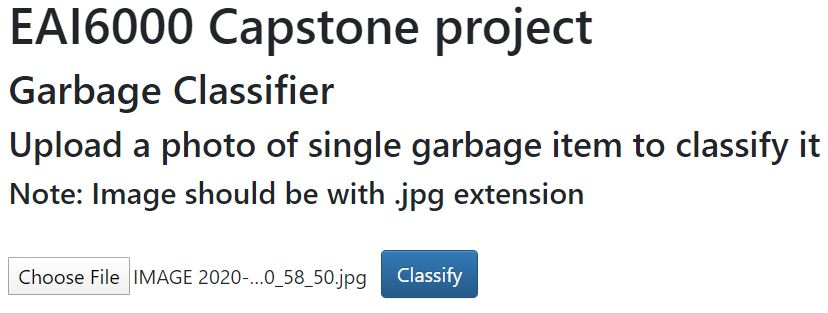

In [13]:
from IPython.display import display, Image
display(Image(filename='Garbage Classifier.jpg'))

Click the "Choose File" button and upload a local garbage image for classification. Then click the "Classify" button to see the result.

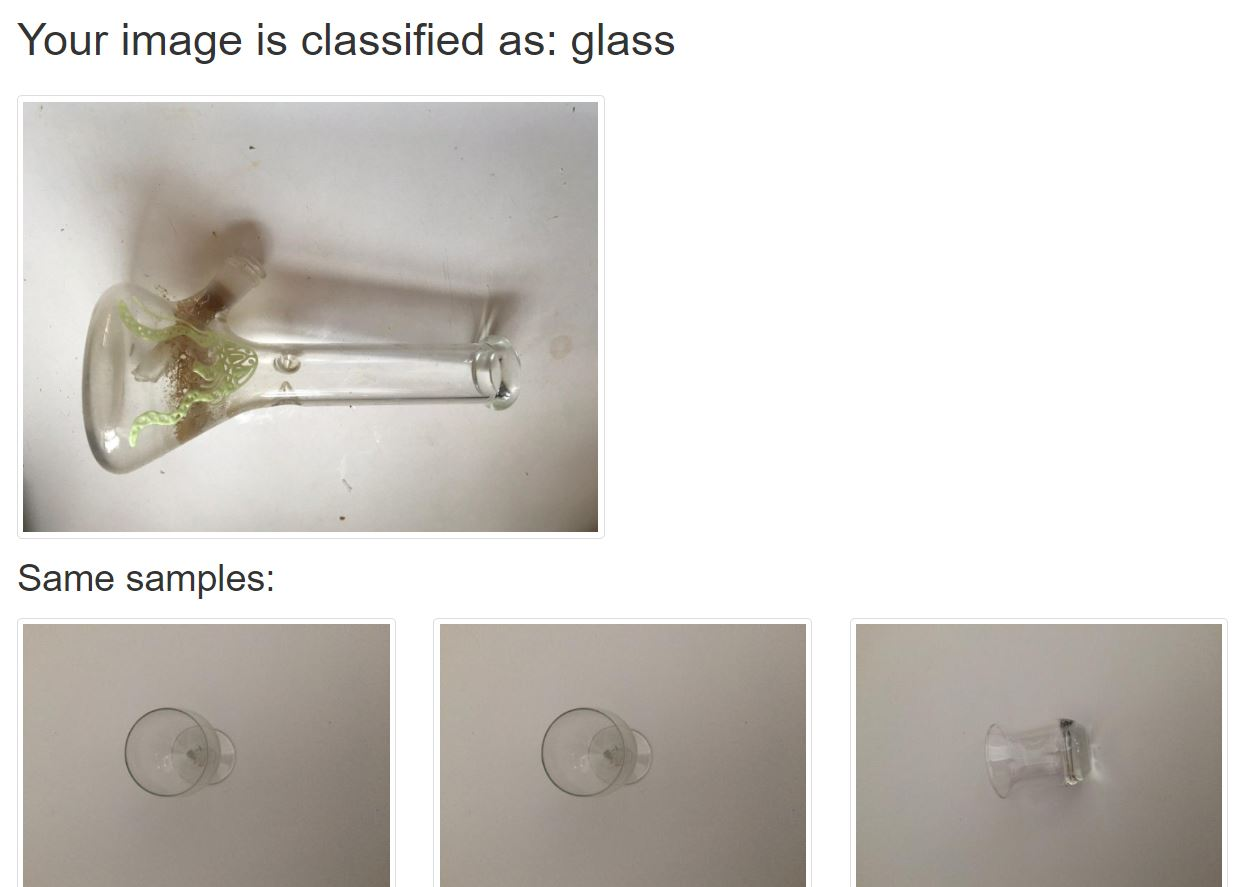

In [14]:
display(Image(filename='Classification-Glass.jpg'))

The above example shows a case that the classifier successfully classified the type of a garbage.
The classifier will display the classification result and some similar images in the original datasets. We strongly encourage to test this application with images of garbages. We've attached a package of garbage photos we took in real life for playing with this application.

Reference: https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c